# Exercise 06
## 1 Bias and variance of ridge regression 

$$\hat \beta = \text{arg}\underset{\beta}{\text{min}}\ \underbrace{||X\beta -y||_2^2+\tau\ ||\beta||_2^2}_{=:B}$$
We will now take the derivative of $B$ with respect to $\beta$ in order to find $\hat \beta$.
$$0\overset{!}{=}\frac{\partial B}{\partial \beta}=
\frac \partial{\partial \beta} \left( ||X\beta-y||^2\right)+\frac \partial{\partial \beta}\left( \tau ||\beta||^2\right)
=2X^\intercal\ \left( X\beta-y\right)+2\tau \beta\\
\Rightarrow X^\intercal y=\left(X^\intercal X+\tau \mathbb{1} \right)\beta\\
\Rightarrow \hat \beta = \left( X^\intercal X+\tau \mathbb{1} \right)^{-1} X^\intercal y = S_{\tau}^{-1} \left( S \beta^*+X^\intercal\epsilon\right)
$$
Now we calculate the expectation value:
$$\mathbb{E}[\hat \beta]=\underbrace{\mathbb E [S_{\tau}^{-1}S\beta^*]}_{S_{\tau}^{-1}S\beta^*}+ \underbrace{\mathbb E [S_{\tau}^{-1}X^\intercal\epsilon]}_{0}=S_{\tau}^{-1}S\beta^*$$

## 2 Denoising of a CT image

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sLA
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
def construct_X(M, alphas, Np = None, tau = 0):
    '''
    M: resulting tomogram size D in one dimension (D=MxM) 
    alphas: list of No angles in degrees
    Np: sensor resolution (optional)
    tau: regularization parameter 
    returns X of shape (Np*No)xD or (Np*No+D)xD if tau is greater than 0
    '''
    #check if tau is not negative:
    if tau<0:
        raise ValueError('tau is negative')
    #convert to numpy array and into radian
    alphas=np.array(alphas)*np.pi/180
    #in case Np is not given we will select one large enough to fit the diagonal of the image beta
    if Np==None:
        Np=np.ceil(np.sqrt(2)*M)
        if Np%2==0: #Np is even
            Np+=1
    
    N=len(alphas)*Np #response vector size
    D=M*M
    #create coordinate matrix C of the ceter of each pixel measured from the center of the image
    
    #"x" distance
    C_0 = np.mod(np.arange(D),M) - (M - 1)/2
    #"y" distance
    C_1 = np.floor_divide(np.arange(D),M) - (M - 1)/2
    #merge for C
    C = np.array([C_0,C_1]).T
    #project the C vector onto the sensor array direction
    translation = C@np.array([np.cos(alphas),np.sin(-alphas)])
    #this is now projected on the senor using the position of the center as reference
    sensorpos = (Np - 1)/ 2 + translation.T
    #first the indices of the smaller pixels then the ones of the larger ones
    i_p = np.array([np.floor(sensorpos), np.ceil(sensorpos)]).flatten()
    #[0]*D,[1]*D,...,[No-1]*D twice repeated
    i_o = np.tile(np.outer(np.arange(len(alphas)),np.ones(D)).flatten(),2)
    #combine them to our i_indices
    i_indices =  i_p + Np * i_o
    
    #simply [0,1,...,No-1]*2D
    j_indices = np.tile(np.tile(np.arange(D),len(alphas)),2)
    
    #compute the weights
    weight_ceil = np.mod(sensorpos, 1).flatten()
    weight_floor = 1 - weight_ceil
    #and combine them in the correct order
    weights = np.append(weight_floor,weight_ceil)
    
    #now we build the matrix X:
    X = sp.coo_matrix((weights, (i_indices, j_indices)),shape = (N,D), dtype = np.float32)
    #if tau=0 we return the X matrix...
    if tau==0:
        return X
    elif tau>0:
        #... if not we return the augmented version X'
        return sp.vstack([X,np.sqrt(tau)*sp.identity(D,format='coo')])
        

In [88]:
def compute_mu(X,y):
    '''
    X: weight matrix of shape (N,D)
    y: sensor data
    returns the image 
    '''
    #use scipy.sparse.linalg.lsqr to calculate beta, also convert X to Compressed Sparse Column format 
    beta=sLA.lsqr(sp.csc_matrix(X),y,atol=1e-5,btol=1e-5)[0]
    #get M from D
    M=int(np.sqrt(len(beta)))
    #return the image mu by reshaping beta
    return beta.reshape(M,M)

In [89]:
alphas = np.load('hs_tomography/alphas_195.npy')
y = np.load('hs_tomography/y_195.npy')

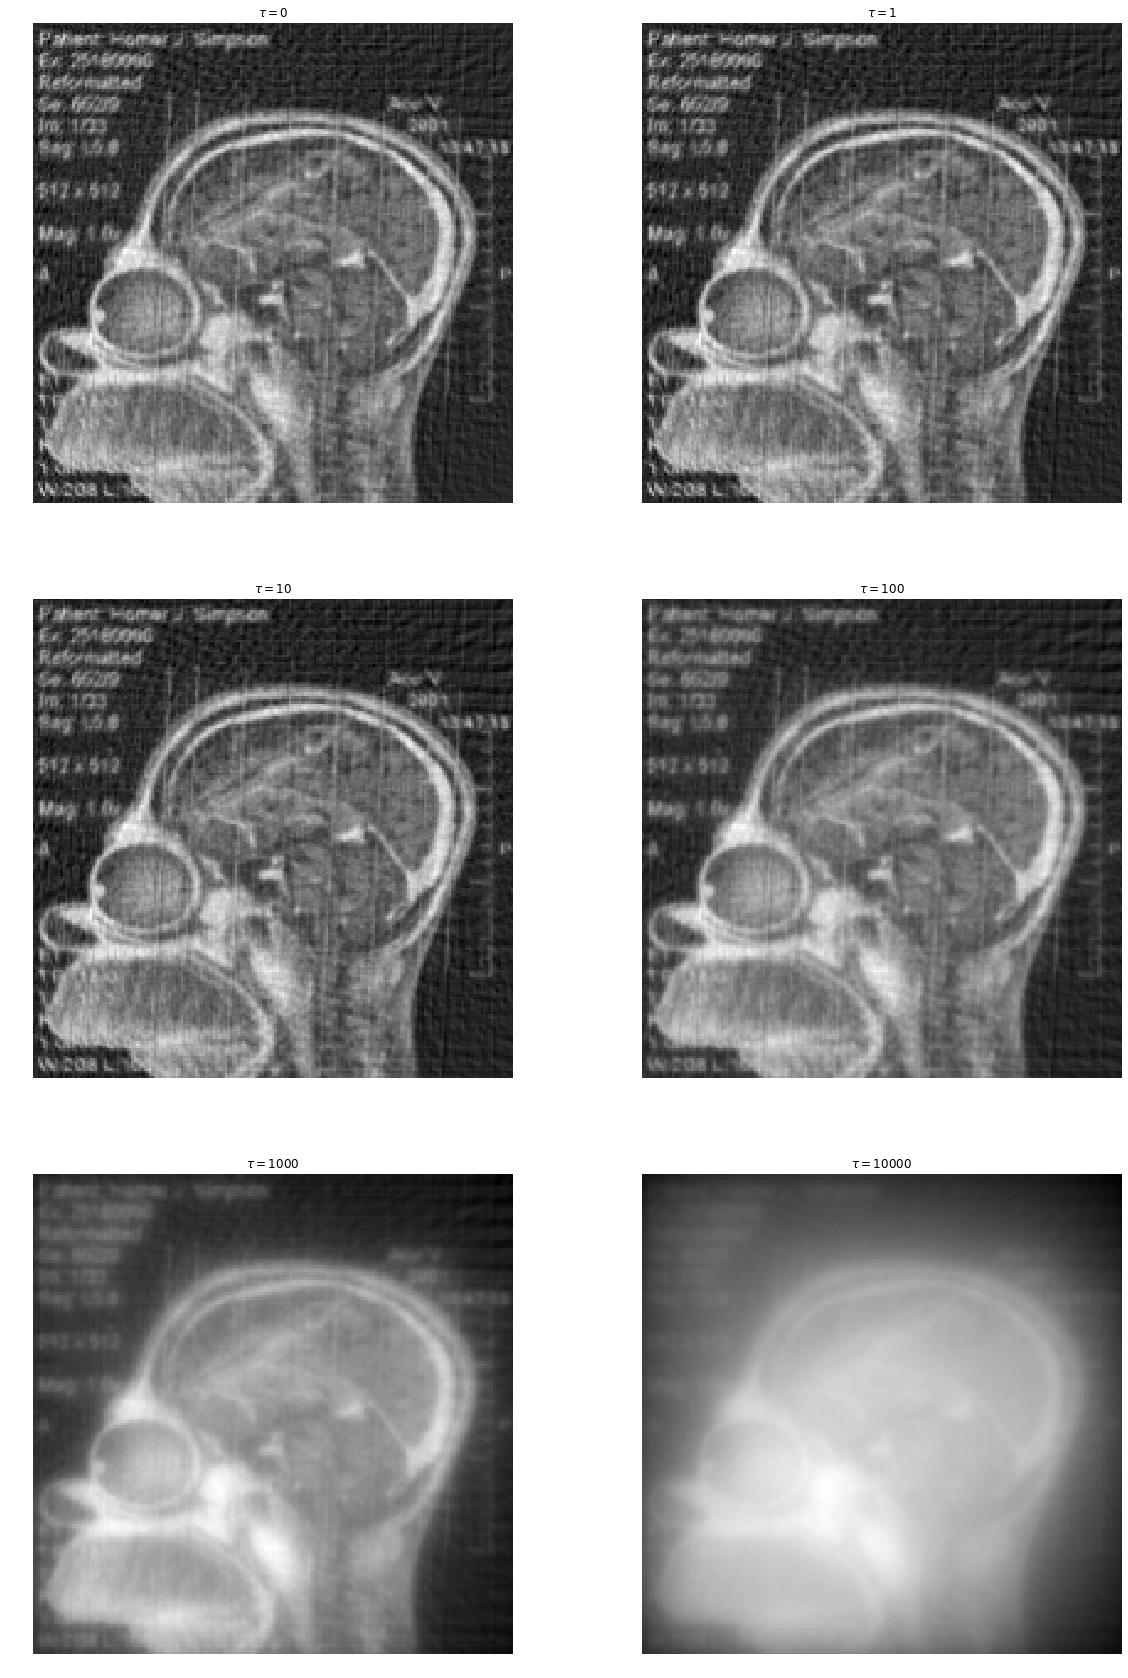

In [92]:
fig=plt.figure(figsize=(20,30))
M,Np,No=195,275,64
#regularization parameter at each step
taus=[0, 1, 10, 100, 1000, 10000]
#64 angels:
indices=[int(np.ceil(len(alphas) * p/No)) for p in range(No)]
angels=alphas[indices]
ys=y.reshape(len(alphas),Np)[indices]
#if tau is not 0 we need to add D zeros
ytau=np.append(ys,np.zeros(M**2))

for i in range(len(taus)):
    fig.add_subplot(int(len(taus)/2),2,1+i)
    plt.gray()
    #select the correct y
    yi=ys if taus[i]==0 else ytau
    plt.imshow(compute_mu(construct_X(M,angels,Np,taus[i]),yi.flatten()))
    plt.title(r'$\tau= %i$'%(taus[i]))
    plt.axis('off')

out of the given $\tau$'s $\tau = 10$ and $\tau=100$ have the best compromise between the noise and the sharpness of the picture without the glowing effect that's visible for larger $\tau$'s. Maybe a better $\tau$ could be found in between the two values $10$ and $100$.

In [93]:
#Now use the gaussian filter
from scipy.ndimage.filters import gaussian_filter

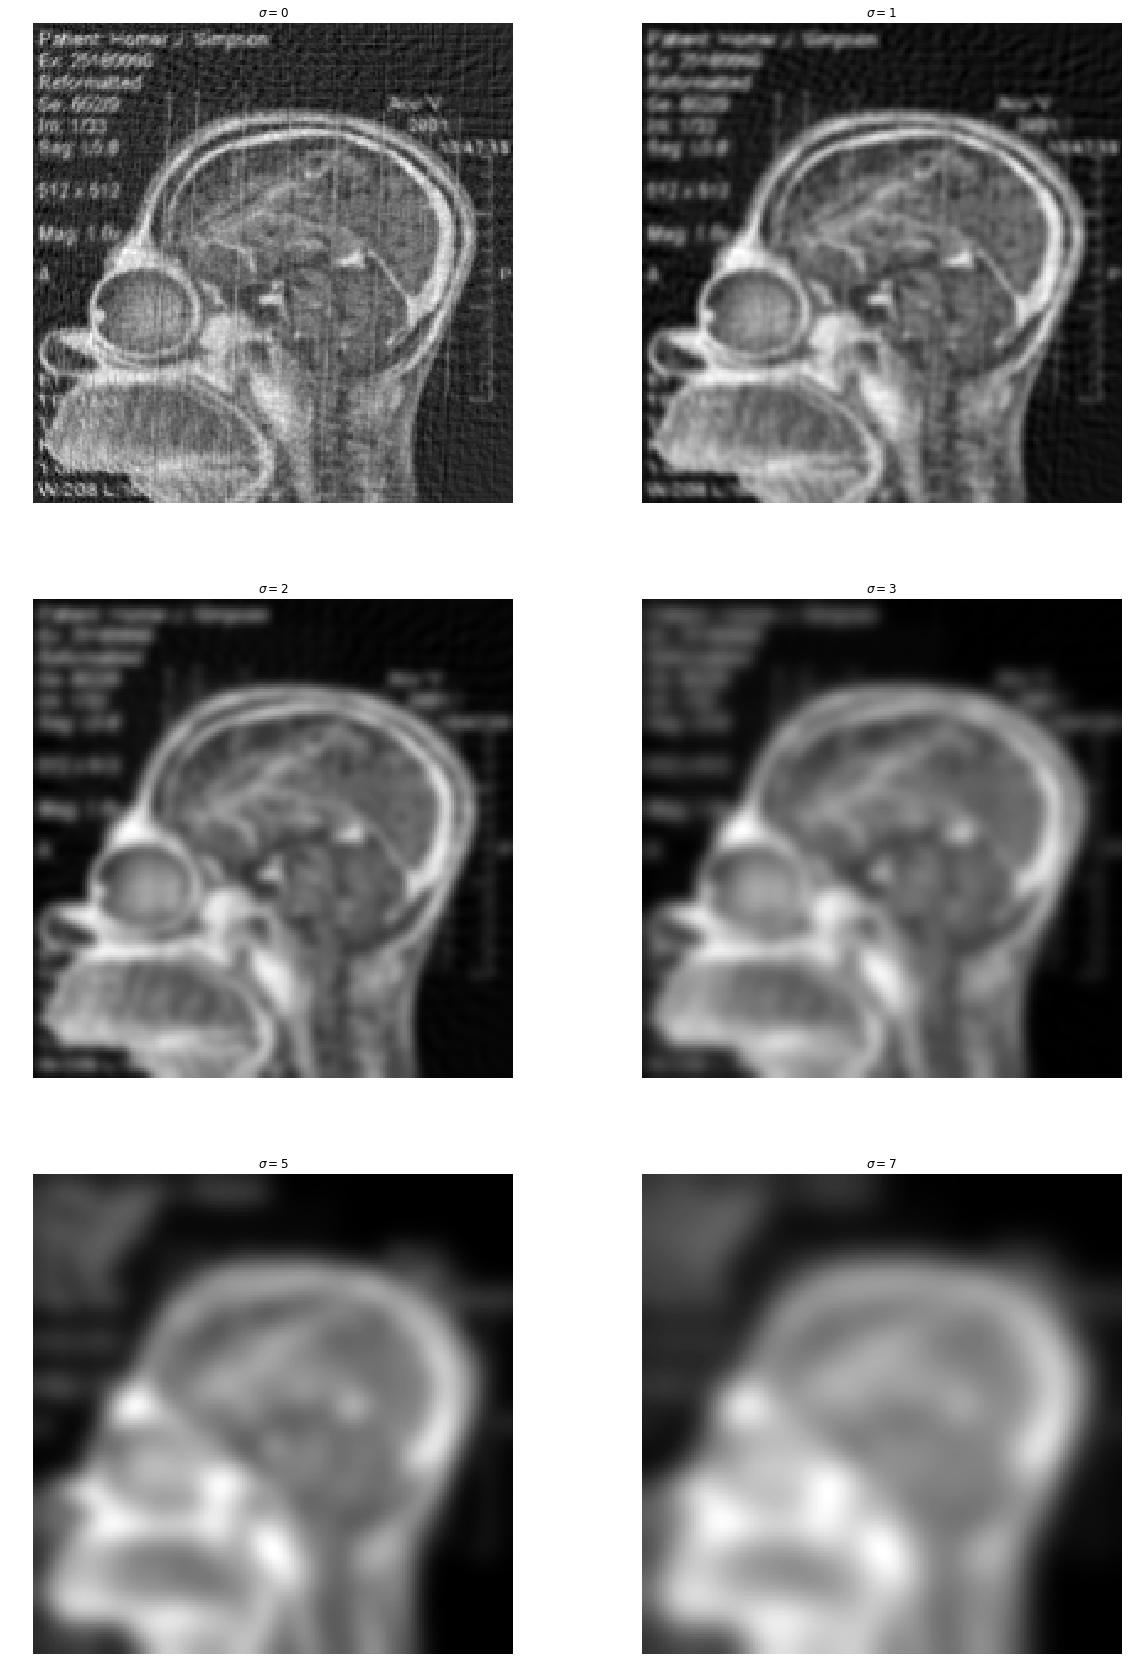

In [98]:
fig=plt.figure(figsize=(20,30))
M,Np,No=195,275,64
#regularization parameter at each step
sig=[0,1,2,3,5,7]
#64 angels:
indices=[int(np.ceil(len(alphas) * p/No)) for p in range(No)]
angels=alphas[indices]
ys=y.reshape(len(alphas),Np)[indices]
#mu for tau=0:
Mu=compute_mu(construct_X(M,angels,Np,0),ys.flatten())
for i in range(len(sig)):
    fig.add_subplot(int(np.ceil(len(sig)/2)),2,1+i)
    plt.gray()
    #select the correct y
    yi=ys if taus[i]==0 else ytau
    plt.imshow(gaussian_filter(Mu,sig[i]))
    plt.title(r'$\sigma= %i$'%(sig[i]))
    plt.axis('off')

For a high sigma the picture becomes blurry. It seems like information is lost. The ridge regression on the other hand develops a glow effect but, so the overall intensity is getting higher but we still can recognize features of the patients face without problems. Both algorithms are denoising the image. The gaussian filter is better at removing the background noise but in the process the image looses sharpness.

## 3 Automatic feature selection for regression

In [26]:
from sklearn.datasets import load_digits
from sklearn import model_selection
#for least squares
from sklearn import linear_model

### 3.1 Implement Orthogonal Matching Pursuit

In [106]:
def omp_regression(X,y,T):
    '''
    X: ndarray with shape (N,D)
    y: ndarray with shape (N)
    T: int >0, desired number of non-zero elements 
    returns a matrix of betas of the shape (D,T)
    '''
    #check if T > 0
    assert T>0
    #Initialization
    A = []
    B = [*range(X.shape[1])] #0...D-1
    r = y
    solutions = []
    #Iteration
    for t in range (1, T + 1):
        corr = np.abs(np.matmul(X.T, r))
        corr[A] = 0 # we are only interested in indices from B
        j = np.argmax(corr)
        A.append(B.pop(B.index(j))) #move the element j from B to A
        X_t = np.delete(X, A, axis = 1)
        #beta = np.linalg.lstsq(X_t, y)[0]
        reg = linear_model.LinearRegression()
        reg.fit(X_t, y)
        beta = reg.coef_
        r = y - np.matmul(X_t,beta)
        beta[A] = 0
        solutions.append(np.insert(beta,(np.sort(A) - np.arange(len(A))).astype(int),0))
        #solutions.append(beta)
    return np.array(solutions)

### 3.2 Classification with sparse LDA 

In [25]:
#load digits
digits = load_digits ()
print(digits.keys ()) #Python 3
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [4]:
# filter out all 1's and 7's
# split into train and test data
X_all = data[(target==1)|(target==7)]
y_all = target[(target==1)|(target==7)]
y_all[y_all == 7] = -1
X_train, X_test, y_train , y_test = model_selection.train_test_split(X_all,y_all,test_size = 0.4,random_state = 0)

In [107]:
x=omp_regression(X_train,y_train,8)